## feeding the trained grid with new test data to generate "fake data"

In [1]:
import os
import json
from argparse import ArgumentParser
from re import split
import numpy as np
from tqdm import tqdm
import imageio
from PIL import Image
np.random.seed(0)

import jax
import jax.numpy as jnp
import plenoxel
from jax.lib import xla_bridge
import json
import random
import copy
import numpy as np
import math
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"


Pick a random test view then projected on a 2D grid

In [2]:
# json file to changed coordinate aka the new training coordinate
file = open('/home/vitran/plenoxels/blender_data/lego/transforms_test.json')
data = json.load(file)
data_gen = copy.deepcopy(data)
frames = []

#taking 10th position
view_sample = data['frames'][10]

#making 2d grid
grid2d = np.zeros((10,10))
x_linspace = np.linspace(start = -0.5, stop = 0.5, num = 10)

for i in x_linspace:
    for j in x_linspace:
        sample = copy.deepcopy(view_sample)
        sample['transform_matrix'][0][-1] += i
        sample['transform_matrix'][1][-1] += j
        print(i,j, sample['transform_matrix'][0][-1],sample['transform_matrix'][1][-1] )
        frames.append(sample)

data_gen['frames'] = frames#json.dumps(frames)
        
file.close()

with open('/home/vitran/plenoxels/blender_data/lego/transforms_test_gen3.json','w') as f:
    json.dump(data_gen, f)

-0.5 -0.5 -2.132938265800476 1.7475464344024658
-0.5 -0.3888888888888889 -2.132938265800476 1.858657545513577
-0.5 -0.2777777777777778 -2.132938265800476 1.9697686566246881
-0.5 -0.16666666666666669 -2.132938265800476 2.0808797677357993
-0.5 -0.05555555555555558 -2.132938265800476 2.1919908788469105
-0.5 0.05555555555555558 -2.132938265800476 2.303101989958021
-0.5 0.16666666666666663 -2.132938265800476 2.4142131010691323
-0.5 0.2777777777777777 -2.132938265800476 2.5253242121802435
-0.5 0.38888888888888884 -2.132938265800476 2.6364353232913547
-0.5 0.5 -2.132938265800476 2.747546434402466
-0.3888888888888889 -0.5 -2.021827154689365 1.7475464344024658
-0.3888888888888889 -0.3888888888888889 -2.021827154689365 1.858657545513577
-0.3888888888888889 -0.2777777777777778 -2.021827154689365 1.9697686566246881
-0.3888888888888889 -0.16666666666666669 -2.021827154689365 2.0808797677357993
-0.3888888888888889 -0.05555555555555558 -2.021827154689365 2.1919908788469105
-0.3888888888888889 0.05555

### Feed the projected coordinates to the trained model to get the images for each view

Helper functions copy from plenoptimize

In [5]:
def get_data(root, stage):
    all_c2w = []
    all_gt = []

    data_path = os.path.join(root, stage)
    data_json = os.path.join(root, 'transforms_' + stage + '.json')
    print('LOAD DATA', data_path)
    j = json.load(open(data_json, 'r'))

    for frame in tqdm(j['frames']):
        fpath = os.path.join(data_path, os.path.basename(frame['file_path']) + '.png')
        c2w = frame['transform_matrix']
#         im_gt = imageio.imread(fpath).astype(np.float32) / 255.0
#         im_gt = im_gt[..., :3] * im_gt[..., 3:] + (1.0 - im_gt[..., 3:])
        all_c2w.append(c2w)
#         all_gt.append(im_gt)
    img0 = imageio.imread('/home/vitran/plenoxels/blender_data/lego/test/r_0.png')
    all_gt.append(img0)
    focal = 0.5 * all_gt[0].shape[1] / np.tan(0.5 * j['camera_angle_x'])
#     all_gt = np.asarray(all_gt)
    all_c2w = np.asarray(all_c2w)
    return focal, all_c2w, all_gt



def get_loss(data_dict, c2w, gt, H, W, focal, resolution, radius, harmonic_degree, jitter, uniform, key, sh_dim, occupancy_penalty, interpolation, nv):
    rays = plenoxel.get_rays(H, W, focal, c2w)
    rgb, disp, acc, weights, voxel_ids = plenoxel.render_rays(data_dict, rays, resolution, key, radius, harmonic_degree, jitter, uniform, interpolation, nv)
    mse = jnp.mean((rgb - lowpass(gt, resolution))**2)
    indices, data = data_dict
    loss = mse + occupancy_penalty * jnp.mean(jax.nn.relu(data[-1]))
    return loss


def get_loss_rays(data_dict, rays, gt, resolution, radius, harmonic_degree, jitter, uniform, key, sh_dim, occupancy_penalty, interpolation, nv):
    rgb, disp, acc, weights, voxel_ids = plenoxel.render_rays(data_dict, rays, resolution, key, radius, harmonic_degree, jitter, uniform, interpolation, nv)
    mse = jnp.mean((rgb - gt)**2)
    indices, data = data_dict
    loss = mse + occupancy_penalty * jnp.mean(jax.nn.relu(data[-1]))
    return loss


def get_rays_np(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32) + 0.5, np.arange(H, dtype=np.float32) + 0.5, indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    # Rotate ray directions from camera frame to the world frame
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d


def render_pose_rays(data_dict, c2w, H, W, focal, resolution, radius, harmonic_degree, jitter, uniform, key, sh_dim, batch_size, interpolation, nv):
    rays_o, rays_d = get_rays_np(H, W, focal, c2w)
    rays_o = np.reshape(rays_o, [-1,3])
    rays_d = np.reshape(rays_d, [-1,3])
    rgbs = []
    disps = []
    for i in range(int(np.ceil(H*W/batch_size))):
        start = i*batch_size
        stop = min(H*W, (i+1)*batch_size)
        if jitter > 0:
            rgbi, dispi, acci, weightsi, voxel_idsi = jax.lax.stop_gradient(plenoxel.render_rays(data_dict, (rays_o[start:stop], rays_d[start:stop]), resolution, key[start:stop], radius, harmonic_degree, jitter, uniform, interpolation, nv))
        else:
            rgbi, dispi, acci, weightsi, voxel_idsi = jax.lax.stop_gradient(plenoxel.render_rays(data_dict, (rays_o[start:stop], rays_d[start:stop]), resolution, None, radius, harmonic_degree, jitter, uniform, interpolation, nv))
        rgbs.append(rgbi)
        disps.append(dispi)
    rgb = jnp.reshape(jnp.concatenate(rgbs, axis=0), (H, W, 3))
    disp = jnp.reshape(jnp.concatenate(disps, axis=0), (H, W))
    return rgb, disp, None, None


Set parameters and load in the trained plenoxel model

In [7]:
# PARAMETERS
resolution = 256
lr_rgb = 150 * (resolution ** 1.75)
lr_sigma = 51.5 * (resolution ** 2.37)
harmonic_degree = 2
jiter = 0.0
automatic_lr = True
uniform = 0.5
physical_batch_size = 1000
interpolation = 'trilinear'
nv = True
radius = 1.3
render_interval = 40
jitter = 0.0

# Load the trained model
focal, train_c2w, train_gt = get_data('/home/vitran/plenoxels/blender_data/lego/', "train")
test_focal, test_c2w, _ = get_data('/home/vitran/plenoxels/blender_data/lego/', "test_gen3")
assert focal == test_focal
H, W = train_gt[0].shape[:2]
#     n_train_imgs = len(train_c2w)
n_test_imgs = len(test_c2w)

reload_dir = '/home/vitran/plenoxels/jax_logs/experiment/epoch_0/' #os.path.join(log_dir, f'epoch_{FLAGS.reload_epoch}')
print(f'Reloading the grid from {reload_dir}')
data_dict = plenoxel.load_grid(dirname=reload_dir, sh_dim = (harmonic_degree + 1)**2)

LOAD DATA /home/vitran/plenoxels/blender_data/lego/train


100%|██████████| 100/100 [00:00<00:00, 170847.41it/s]


LOAD DATA /home/vitran/plenoxels/blender_data/lego/test_gen3


100%|██████████| 100/100 [00:00<00:00, 392725.09it/s]

Reloading the grid from /home/vitran/plenoxels/jax_logs/experiment/epoch_0/


Feed coordinates to the model to output image of the view

In [ ]:
def run_test_step(i, data_dict, test_c2w, test_gt, H, W, focal, FLAGS, key, name_appendage=''):
    print('Evaluating')
    sh_dim = (harmonic_degree + 1)**2
    tpsnr = 0.0
    for j, (c2w, _) in tqdm(enumerate(zip(test_c2w, test_gt))):
        print(c2w[1].shape)
        print(c2w)
        rgb, disp, _, _ = render_pose_rays(data_dict, c2w, H, W, focal, resolution, radius, harmonic_degree, jitter, uniform, key, sh_dim, physical_batch_size, interpolation, nv)
#         mse = jnp.mean((rgb - gt)**2)
#         psnr = -10.0 * np.log(mse) / np.log(10.0)
#         tpsnr += psnr

#         if render_interval > 0 and j % render_interval == 0:
#             disp3 = jnp.concatenate((disp[...,jnp.newaxis], disp[...,jnp.newaxis], disp[...,jnp.newaxis]), axis=2)
#             vis = jnp.concatenate((gt, rgb, disp3), axis=1)
        print(j)
        vis = np.asarray((rgb * 255)).astype(np.uint8)
        imageio.imwrite(f"/home/vitran/plenoxels/jax_logs/lego_generate3/{j:04}_{i:04}{name_appendage}.png", vis)
#         del rgb, disp
#     tpsnr /= n_test_imgs
#     return tpsnr
keys = jax.vmap(jax.random.PRNGKey, in_axes=0, out_axes=0)(jnp.arange(physical_batch_size))
test_gt = np.ones_like(test_c2w)
run_test_step(0, data_dict, test_c2w, test_gt, H, W, focal, None, None)


Evaluating


0it [00:00, ?it/s]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.74754643e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0


1it [02:02, 122.07s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.85865755e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
1


2it [04:04, 122.14s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.96976866e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
2


3it [06:06, 122.19s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.08087977e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
3


4it [08:08, 122.21s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.19199088e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
4


5it [10:10, 122.22s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.30310199e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
5


6it [12:13, 122.22s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.41421310e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
6


7it [14:15, 122.24s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.52532421e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
7


8it [16:17, 122.25s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.63643532e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
8


9it [18:20, 122.25s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.13293827e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.74754643e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
9


10it [20:22, 122.26s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.74754643e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
10


11it [22:24, 122.25s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.85865755e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
11


12it [24:26, 122.23s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.96976866e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
12


13it [26:28, 122.25s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.08087977e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
13


14it [28:31, 122.26s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.19199088e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
14


15it [30:33, 122.27s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.30310199e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
15


16it [32:35, 122.28s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.41421310e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
16


17it [34:38, 122.29s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.52532421e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
17


18it [36:40, 122.29s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.63643532e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
18


19it [38:42, 122.30s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -2.02182715e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.74754643e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
19


20it [40:45, 122.29s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.74754643e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
20


21it [42:47, 122.28s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.85865755e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
21


22it [44:49, 122.28s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.96976866e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
22


23it [46:51, 122.29s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.08087977e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
23


24it [48:54, 122.30s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.19199088e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
24


25it [50:56, 122.30s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.30310199e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
25


26it [52:58, 122.30s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.41421310e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
26


27it [55:01, 122.29s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.52532421e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
27


28it [57:03, 122.28s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.63643532e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
28


29it [59:05, 122.29s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.91071604e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  2.74754643e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
29


30it [1:01:07, 122.29s/it]

(4,)
[[-8.09016943e-01  4.25910890e-01 -4.05082136e-01 -1.79960493e+00]
 [-5.87785363e-01 -5.86215913e-01  5.57547629e-01  1.74754643e+00]
 [ 1.49011612e-08  6.89166725e-01  7.24602759e-01  2.92096710e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Model output

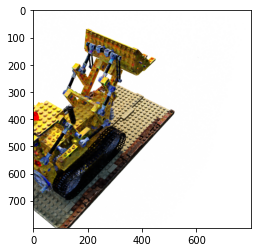

In [34]:
key = jax.vmap(jax.random.PRNGKey, in_axes=0, out_axes=0)(jnp.arange(physical_batch_size))
sh_dim = (harmonic_degree + 1)**2
c2w = test_c2w[0]
rgb, disp, _, _ = render_pose_rays(data_dict, c2w, H, W, focal, resolution, radius, harmonic_degree, jitter, uniform, key, sh_dim, physical_batch_size, interpolation, nv)
plt.imshow(rgb)

## Reformating the fake training json file

In [ ]:
# change images name
import os
basedir = "/home/vitran/plenoxels/blender_data/lego_gen3/train/"
for file in os.listdir(basedir):
    if file[-3:]=='png':
        cnt = int(file[2:4])
        newname = "r_"+str(cnt)
        os.rename(basedir+file, basedir+f"r_{str(cnt)}.png")

Assigning image view with the corresponding coordinate

In [60]:
file = open('/home/vitran/plenoxels/blender_data/lego_gen3/transforms_test.json')
data = json.load(file)
cnt = 0
for img in data['frames']:
    img['file_path'] = './train/r_'+str(cnt)
    cnt+=1
    a = img['file_path']
    print(a)

# data_gen['frames'] = frames#json.dumps(frames)
        
file.close()

# with open('/home/vitran/plenoxels/blender_data/lego_gen3/transforms_train.json','w') as f:
#     json.dump(data, f)

./train/r_0
./train/r_1
./train/r_2
./train/r_3
./train/r_4
./train/r_5
./train/r_6
./train/r_7
./train/r_8
./train/r_9
./train/r_10
./train/r_11
./train/r_12
./train/r_13
./train/r_14
./train/r_15
./train/r_16
./train/r_17
./train/r_18
./train/r_19
./train/r_20
./train/r_21
./train/r_22
./train/r_23
./train/r_24
./train/r_25
./train/r_26
./train/r_27
./train/r_28
./train/r_29
./train/r_30
./train/r_31
./train/r_32
./train/r_33
./train/r_34
./train/r_35
./train/r_36
./train/r_37
./train/r_38
./train/r_39
./train/r_40
./train/r_41
./train/r_42
./train/r_43
./train/r_44
./train/r_45
./train/r_46
./train/r_47
./train/r_48
./train/r_49
./train/r_50
./train/r_51
./train/r_52
./train/r_53
./train/r_54
./train/r_55
./train/r_56
./train/r_57
./train/r_58
./train/r_59
./train/r_60
./train/r_61
./train/r_62
./train/r_63
./train/r_64
./train/r_65
./train/r_66
./train/r_67
./train/r_68
./train/r_69
./train/r_70
./train/r_71
./train/r_72
./train/r_73
./train/r_74
./train/r_75
./train/r_76
./train/r

Debugging missing alpha channel from the input data

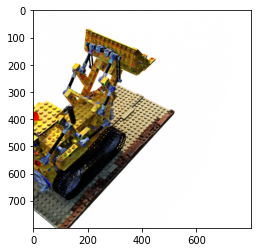

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_0.png
shape here (800, 800, 3) new shape  (800, 800)


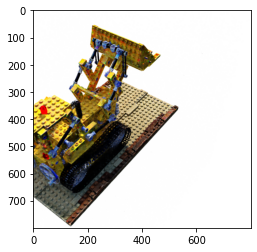

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_1.png
shape here (800, 800, 3) new shape  (800, 800)


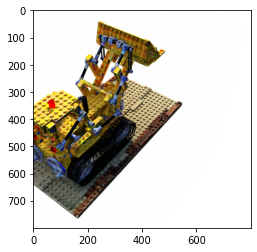

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_2.png
shape here (800, 800, 3) new shape  (800, 800)


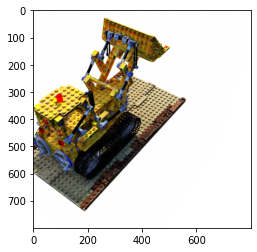

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_3.png
shape here (800, 800, 3) new shape  (800, 800)


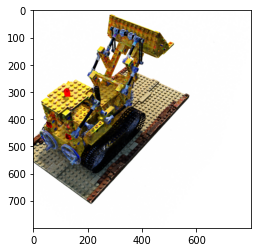

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_4.png
shape here (800, 800, 3) new shape  (800, 800)


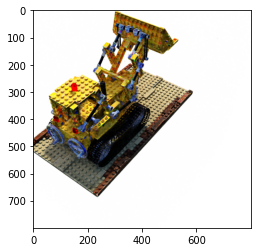

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_5.png
shape here (800, 800, 3) new shape  (800, 800)


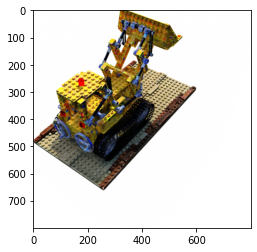

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_6.png
shape here (800, 800, 3) new shape  (800, 800)


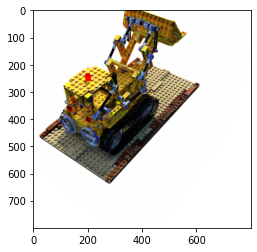

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_7.png
shape here (800, 800, 3) new shape  (800, 800)


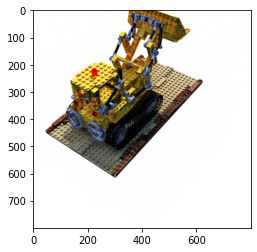

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_8.png
shape here (800, 800, 3) new shape  (800, 800)


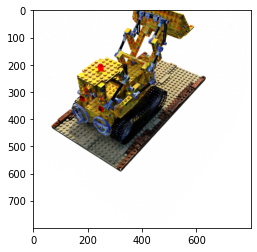

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_9.png
shape here (800, 800, 3) new shape  (800, 800)


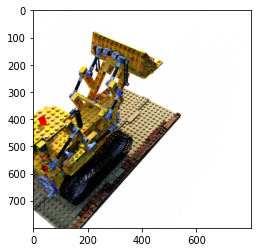

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_10.png
shape here (800, 800, 3) new shape  (800, 800)


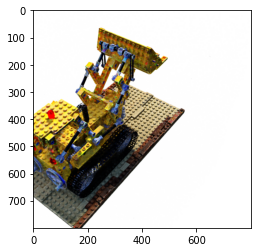

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_11.png
shape here (800, 800, 3) new shape  (800, 800)


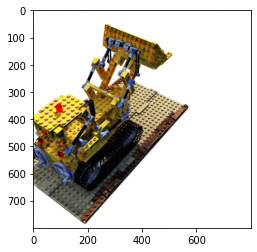

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_12.png
shape here (800, 800, 3) new shape  (800, 800)


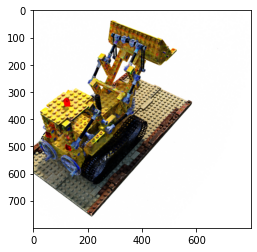

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_13.png
shape here (800, 800, 3) new shape  (800, 800)


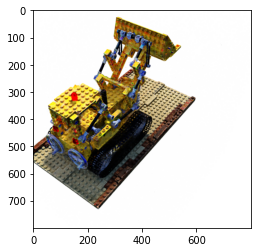

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_14.png
shape here (800, 800, 3) new shape  (800, 800)


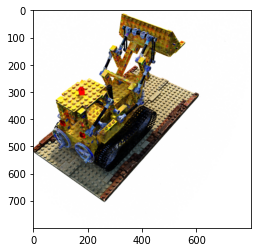

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_15.png
shape here (800, 800, 3) new shape  (800, 800)


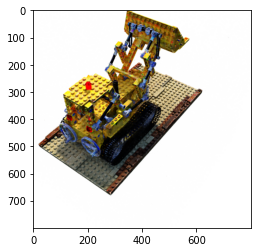

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_16.png
shape here (800, 800, 3) new shape  (800, 800)


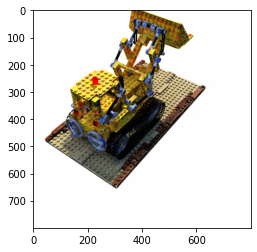

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_17.png
shape here (800, 800, 3) new shape  (800, 800)


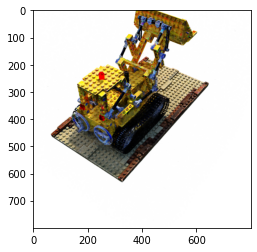

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_18.png
shape here (800, 800, 3) new shape  (800, 800)


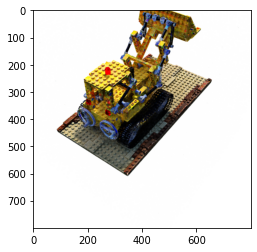

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_19.png
shape here (800, 800, 3) new shape  (800, 800)


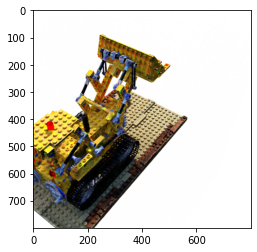

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_20.png
shape here (800, 800, 3) new shape  (800, 800)


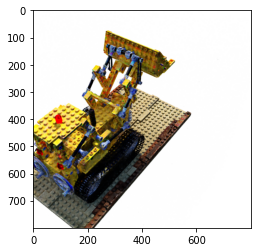

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_21.png
shape here (800, 800, 3) new shape  (800, 800)


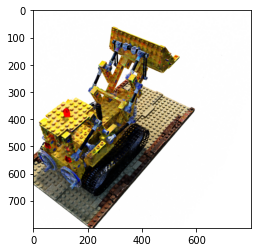

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_22.png
shape here (800, 800, 3) new shape  (800, 800)


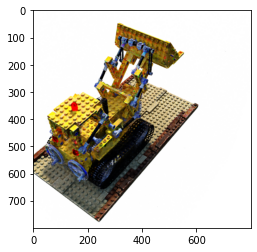

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_23.png
shape here (800, 800, 3) new shape  (800, 800)


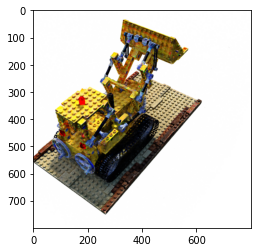

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_24.png
shape here (800, 800, 3) new shape  (800, 800)


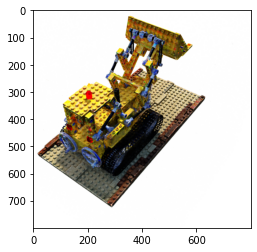

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_25.png
shape here (800, 800, 3) new shape  (800, 800)


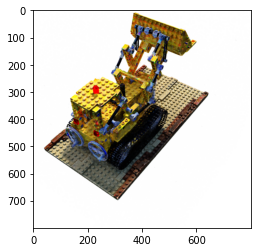

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_26.png
shape here (800, 800, 3) new shape  (800, 800)


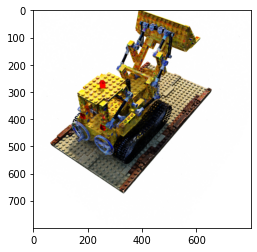

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_27.png
shape here (800, 800, 3) new shape  (800, 800)


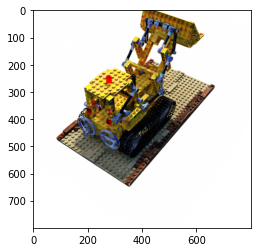

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_28.png
shape here (800, 800, 3) new shape  (800, 800)


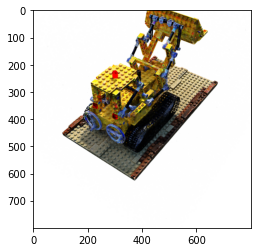

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_29.png
shape here (800, 800, 3) new shape  (800, 800)


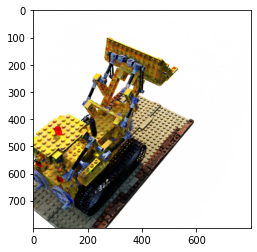

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_30.png
shape here (800, 800, 3) new shape  (800, 800)


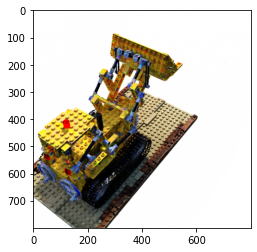

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_31.png
shape here (800, 800, 3) new shape  (800, 800)


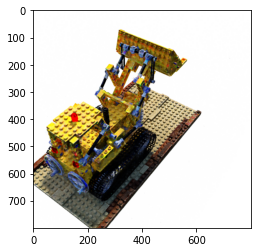

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_32.png
shape here (800, 800, 3) new shape  (800, 800)


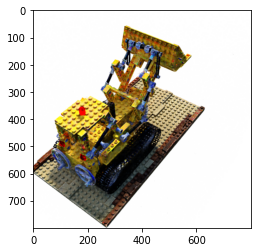

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_33.png
shape here (800, 800, 3) new shape  (800, 800)


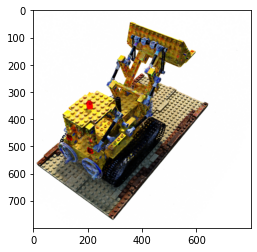

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_34.png
shape here (800, 800, 3) new shape  (800, 800)


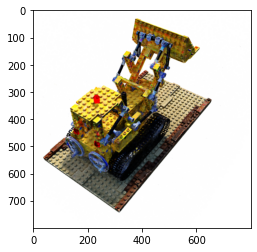

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_35.png
shape here (800, 800, 3) new shape  (800, 800)


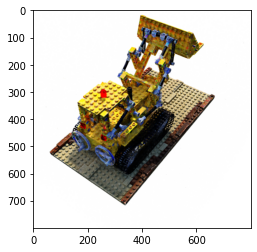

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_36.png
shape here (800, 800, 3) new shape  (800, 800)


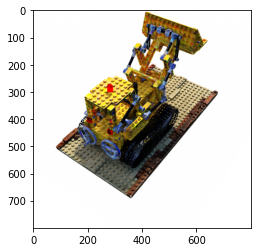

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_37.png
shape here (800, 800, 3) new shape  (800, 800)


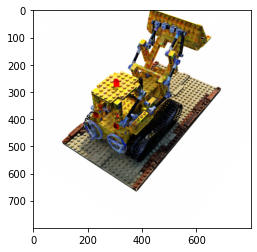

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_38.png
shape here (800, 800, 3) new shape  (800, 800)


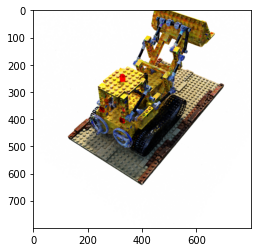

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_39.png
shape here (800, 800, 3) new shape  (800, 800)


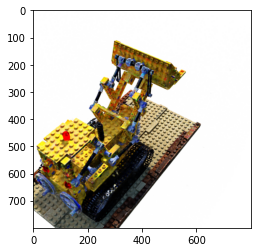

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_40.png
shape here (800, 800, 3) new shape  (800, 800)


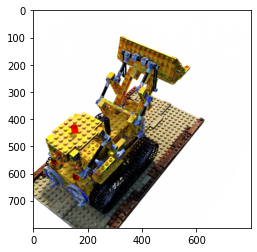

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_41.png
shape here (800, 800, 3) new shape  (800, 800)


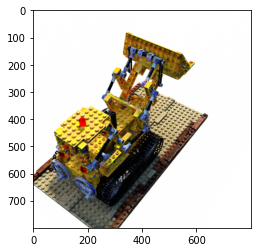

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_42.png
shape here (800, 800, 3) new shape  (800, 800)


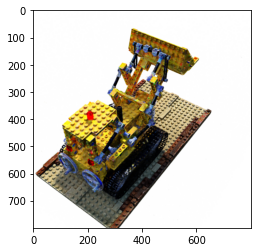

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_43.png
shape here (800, 800, 3) new shape  (800, 800)


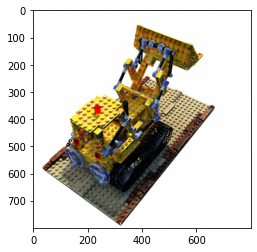

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_44.png
shape here (800, 800, 3) new shape  (800, 800)


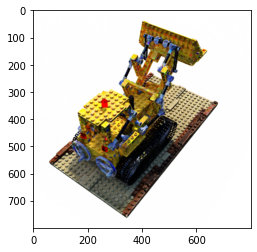

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_45.png
shape here (800, 800, 3) new shape  (800, 800)


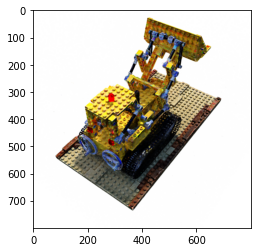

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_46.png
shape here (800, 800, 3) new shape  (800, 800)


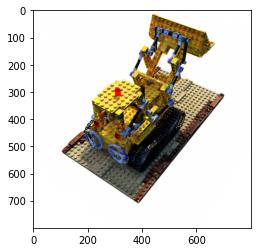

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_47.png
shape here (800, 800, 3) new shape  (800, 800)


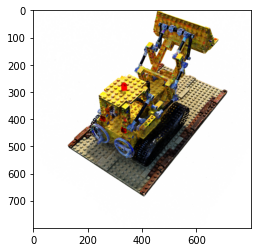

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_48.png
shape here (800, 800, 3) new shape  (800, 800)


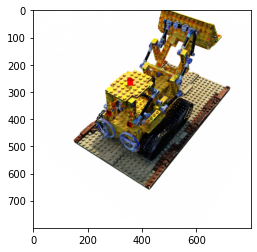

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_49.png
shape here (800, 800, 3) new shape  (800, 800)


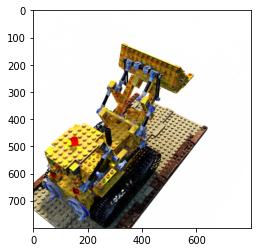

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_50.png
shape here (800, 800, 3) new shape  (800, 800)


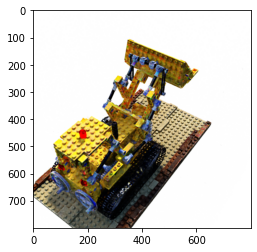

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_51.png
shape here (800, 800, 3) new shape  (800, 800)


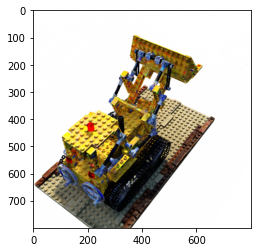

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_52.png
shape here (800, 800, 3) new shape  (800, 800)


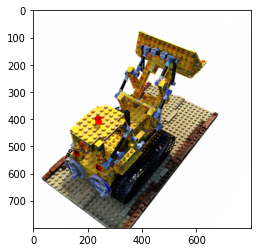

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_53.png
shape here (800, 800, 3) new shape  (800, 800)


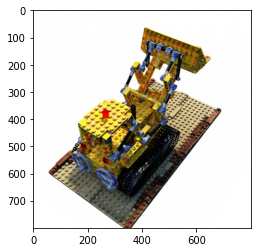

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_54.png
shape here (800, 800, 3) new shape  (800, 800)


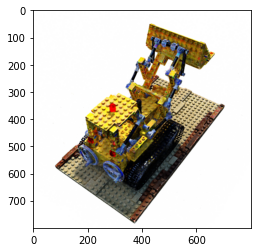

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_55.png
shape here (800, 800, 3) new shape  (800, 800)


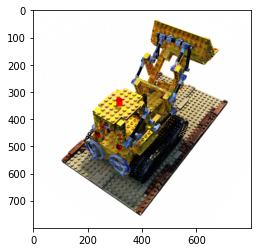

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_56.png
shape here (800, 800, 3) new shape  (800, 800)


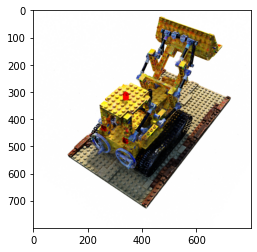

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_57.png
shape here (800, 800, 3) new shape  (800, 800)


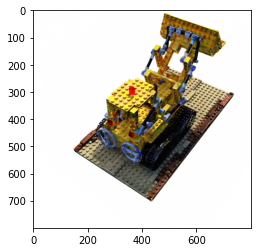

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_58.png
shape here (800, 800, 3) new shape  (800, 800)


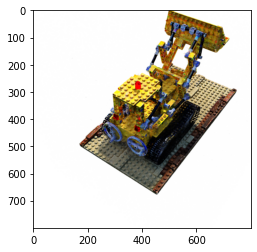

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_59.png
shape here (800, 800, 3) new shape  (800, 800)


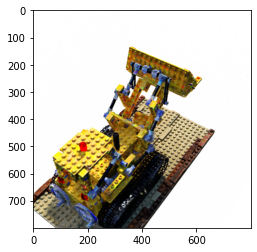

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_60.png
shape here (800, 800, 3) new shape  (800, 800)


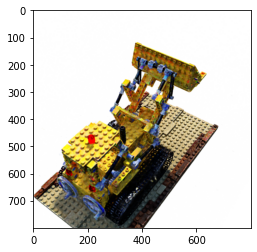

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_61.png
shape here (800, 800, 3) new shape  (800, 800)


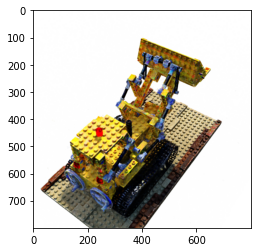

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_62.png
shape here (800, 800, 3) new shape  (800, 800)


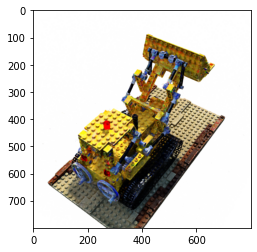

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_63.png
shape here (800, 800, 3) new shape  (800, 800)


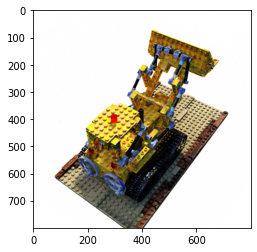

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_64.png
shape here (800, 800, 3) new shape  (800, 800)


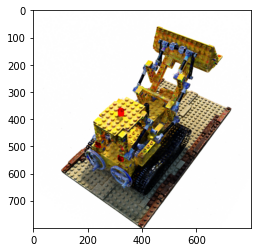

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_65.png
shape here (800, 800, 3) new shape  (800, 800)


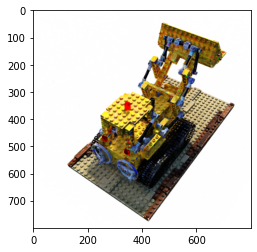

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_66.png
shape here (800, 800, 3) new shape  (800, 800)


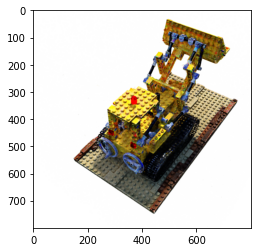

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_67.png
shape here (800, 800, 3) new shape  (800, 800)


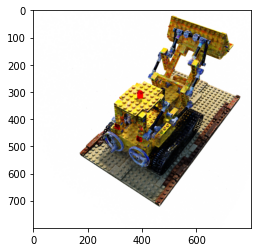

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_68.png
shape here (800, 800, 3) new shape  (800, 800)


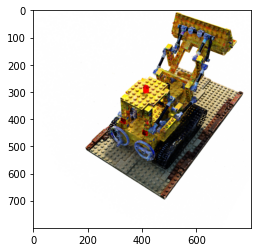

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_69.png
shape here (800, 800, 3) new shape  (800, 800)


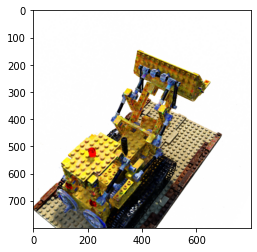

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_70.png
shape here (800, 800, 3) new shape  (800, 800)


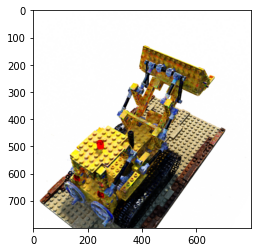

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_71.png
shape here (800, 800, 3) new shape  (800, 800)


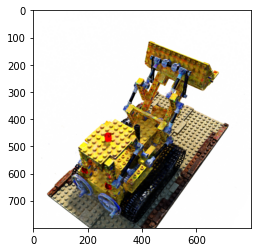

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_72.png
shape here (800, 800, 3) new shape  (800, 800)


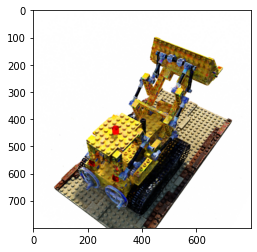

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_73.png
shape here (800, 800, 3) new shape  (800, 800)


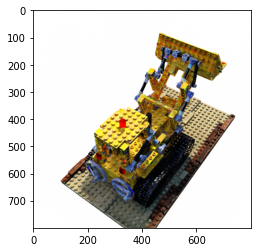

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_74.png
shape here (800, 800, 3) new shape  (800, 800)


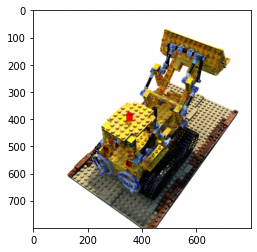

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_75.png
shape here (800, 800, 3) new shape  (800, 800)


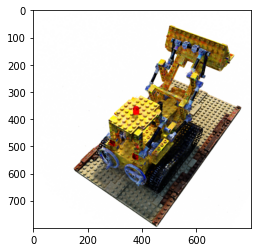

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_76.png
shape here (800, 800, 3) new shape  (800, 800)


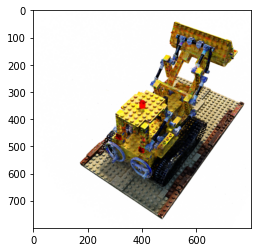

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_77.png
shape here (800, 800, 3) new shape  (800, 800)


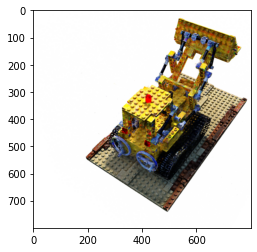

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_78.png
shape here (800, 800, 3) new shape  (800, 800)


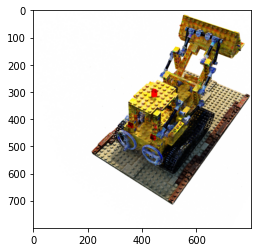

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_79.png
shape here (800, 800, 3) new shape  (800, 800)


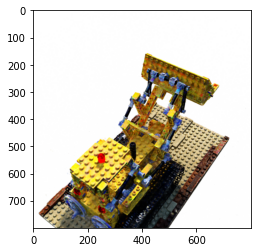

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_80.png
shape here (800, 800, 3) new shape  (800, 800)


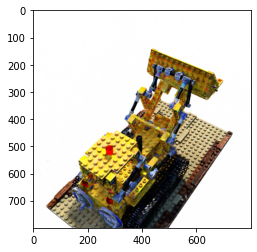

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_81.png
shape here (800, 800, 3) new shape  (800, 800)


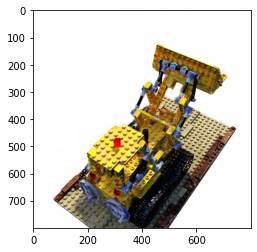

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_82.png
shape here (800, 800, 3) new shape  (800, 800)


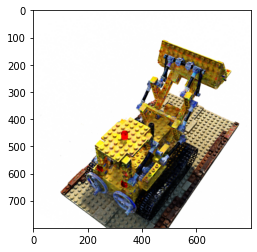

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_83.png
shape here (800, 800, 3) new shape  (800, 800)


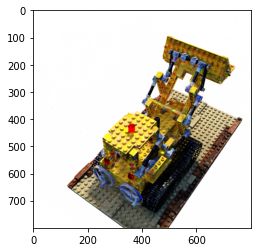

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_84.png
shape here (800, 800, 3) new shape  (800, 800)


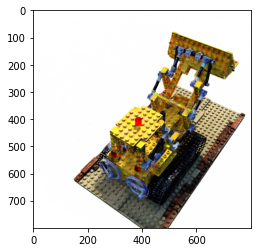

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_85.png
shape here (800, 800, 3) new shape  (800, 800)


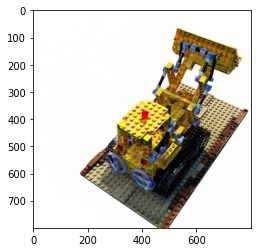

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_86.png
shape here (800, 800, 3) new shape  (800, 800)


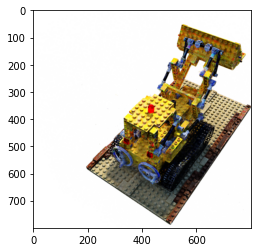

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_87.png
shape here (800, 800, 3) new shape  (800, 800)


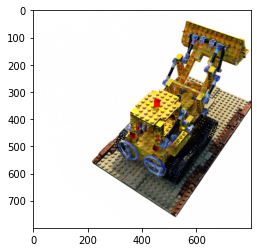

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_88.png
shape here (800, 800, 3) new shape  (800, 800)


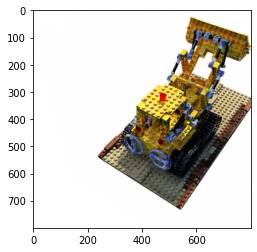

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_89.png
shape here (800, 800, 3) new shape  (800, 800)


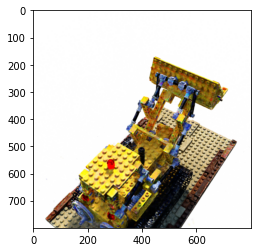

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_90.png
shape here (800, 800, 3) new shape  (800, 800)


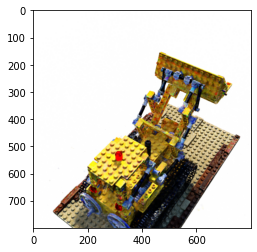

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_91.png
shape here (800, 800, 3) new shape  (800, 800)


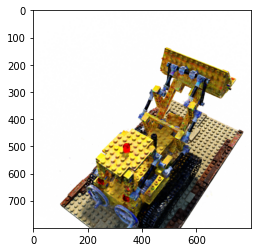

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_92.png
shape here (800, 800, 3) new shape  (800, 800)


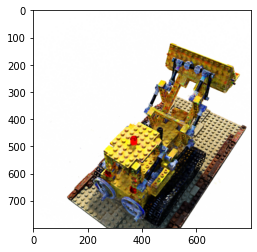

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_93.png
shape here (800, 800, 3) new shape  (800, 800)


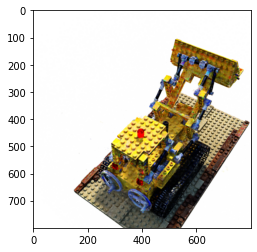

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_94.png
shape here (800, 800, 3) new shape  (800, 800)


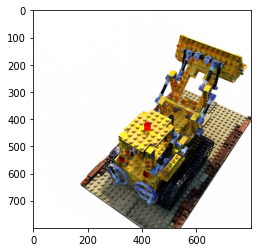

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_95.png
shape here (800, 800, 3) new shape  (800, 800)


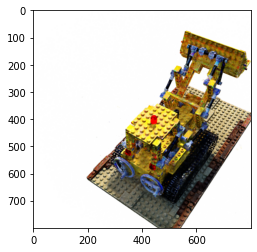

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_96.png
shape here (800, 800, 3) new shape  (800, 800)


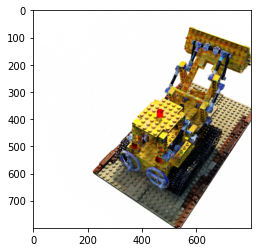

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_97.png
shape here (800, 800, 3) new shape  (800, 800)


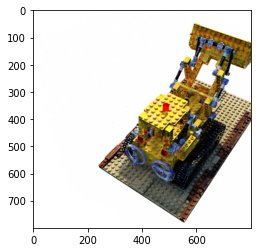

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_98.png
shape here (800, 800, 3) new shape  (800, 800)


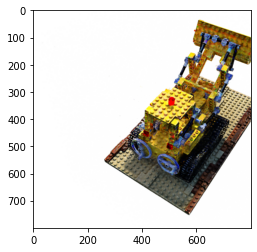

/home/vitran/plenoxels/blender_data/lego_gen3/train2/r_99.png
shape here (800, 800, 3) new shape  (800, 800)


In [25]:
data_path = '/home/vitran/plenoxels/blender_data/lego_gen3/'
data_json = '/home/vitran/plenoxels/blender_data/lego_gen3/transforms_train.json'

# data_path = '/home/vitran/plenoxels/blender_data/lego/'
# data_json = '/home/vitran/plenoxels/blender_data/lego/transforms_train.json'

j = json.load(open(data_json, 'r'))
for frame in j['frames']:
    fpath = os.path.join(data_path+'train/', os.path.basename(frame['file_path']) + '.png')
    im_gt = imageio.imread(fpath).astype(np.float32) / 255.0
    ones = np.ones((800,800,1))
    im_gt_add = np.concatenate((im_gt, ones),2)
    plt.imshow(im_gt_add)
    plt.show()
    img_add = Image.fromarray((im_gt_add * 255).astype(np.uint8))
    fsave = os.path.join(data_path+'train2/', os.path.basename(frame['file_path']) + '.png')
    img_add.save(fsave)
    print(fsave)
    print('shape here', im_gt.shape, 'new shape ', img_add.size)

Add alpha channel to fake ground truth data

In [17]:
from PIL import Image